In [1]:
# -*- encoding: utf-8 -*-

"""
@Author: Gavin
@File: titanic_prediction.py
@Software: Pycharm
@Time: 2021/2/19
@Desc:
    1.kaggle入门比赛
    2.泰坦尼克号存活乘客预测
"""

'\n@Author: Gavin\n@File: titanic_prediction.py\n@Software: Pycharm\n@Time: 2021/2/19\n@Desc:\n    1.kaggle入门比赛\n    2.泰坦尼克号存活乘客预测\n'

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import set_option
from pathlib import Path


project_path = Path.cwd().parent
project_path

seed = 42

In [2]:
# 数据集
if not os.path.exists(str(Path(project_path, "datasets/train.csv"))) or \
    not os.path.exists(str(Path(project_path, "datasets/test.csv"))):

    raise FileNotFoundError(
        "数据集不存在，请检查：{}".format(
            str(Path(project_path, "datasets/titanic.zip"))))

In [3]:
# 加载数据集并简要查看数据集
train_file = pd.read_csv(str(Path(project_path, "datasets/train.csv")))
test_file = pd.read_csv(str(Path(project_path, "datasets/test.csv")))
set_option("display.width", 200)
set_option("display.max_columns", 20)
train_file.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test_file.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
# 查看数据结构
print("train csv info: \n", train_file.info())
print("test csv info: \n", test_file.info())
print("train csv describe\n", train_file.describe())
print("test csv  describe\n", test_file.describe())

# 可看出训练集中age、cabin、embarked有空值，测试集中age、fare、cabin有空值
# 标签中正负样本比例11:7，可能有不均衡的情况出现
# Sex、Ticket、carbin、Embarked需要转化成数值特征
# 需要对数值特征做标准化或归一化处理

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
train csv info: 
 None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare      

In [34]:
# 创建验证集
# (因为数据集标签1和标签0的比例为11：7，所以在进行抽样的时候采用分层抽样，保持数据分布的一致性)
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
for train_index, val_index in split.split(train_file, train_file["Survived"]):
    train_set =  train_file.loc[train_index]
    dev_set =  train_file.loc[val_index]

train_set.info()
# 可看出Age、cabin、embarked有空值
# 由于age空值不多，但是占用一定的比例，因此用平均年龄去替换空值
# cabin空值太多，而且属于类别，因此删除cabin属性
# embarked空值用中位数去填充
# 可看出name、sex、ticket、carbin、embarked是文本对象，因此将他们转化为数值对象
# 其中name、cabin属性删除

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 692 to 507
Data columns (total 12 columns):
PassengerId    712 non-null int64
Survived       712 non-null int64
Pclass         712 non-null int64
Name           712 non-null object
Sex            712 non-null object
Age            575 non-null float64
SibSp          712 non-null int64
Parch          712 non-null int64
Ticket         712 non-null object
Fare           712 non-null float64
Cabin          160 non-null object
Embarked       710 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


In [35]:
dev_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 565 to 637
Data columns (total 12 columns):
PassengerId    179 non-null int64
Survived       179 non-null int64
Pclass         179 non-null int64
Name           179 non-null object
Sex            179 non-null object
Age            139 non-null float64
SibSp          179 non-null int64
Parch          179 non-null int64
Ticket         179 non-null object
Fare           179 non-null float64
Cabin          44 non-null object
Embarked       179 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 18.2+ KB


In [ ]:
# 简要将数据中文本数据转化成数值特征，再观察
from sklearn.preprocessing import LabelEncoder

tmp_encoder = LabelEncoder()
tmp_cat_attribs = ["Sex", "Cabin", "Embarked"]
tmp_train_dev = train_set

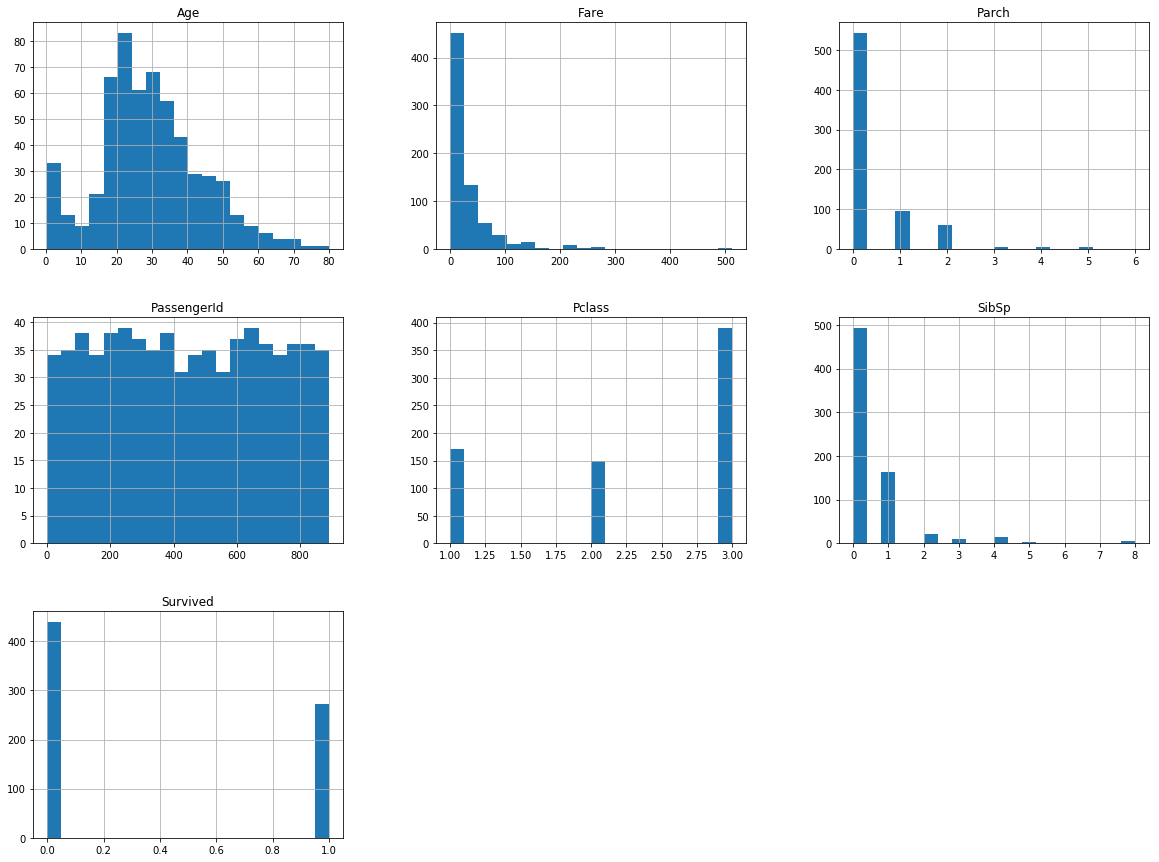

In [36]:
# 画图展示
train_set.hist(bins=20, figsize=(20, 15))
plt.tick_params(axis='x',colors='w')

plt.show()

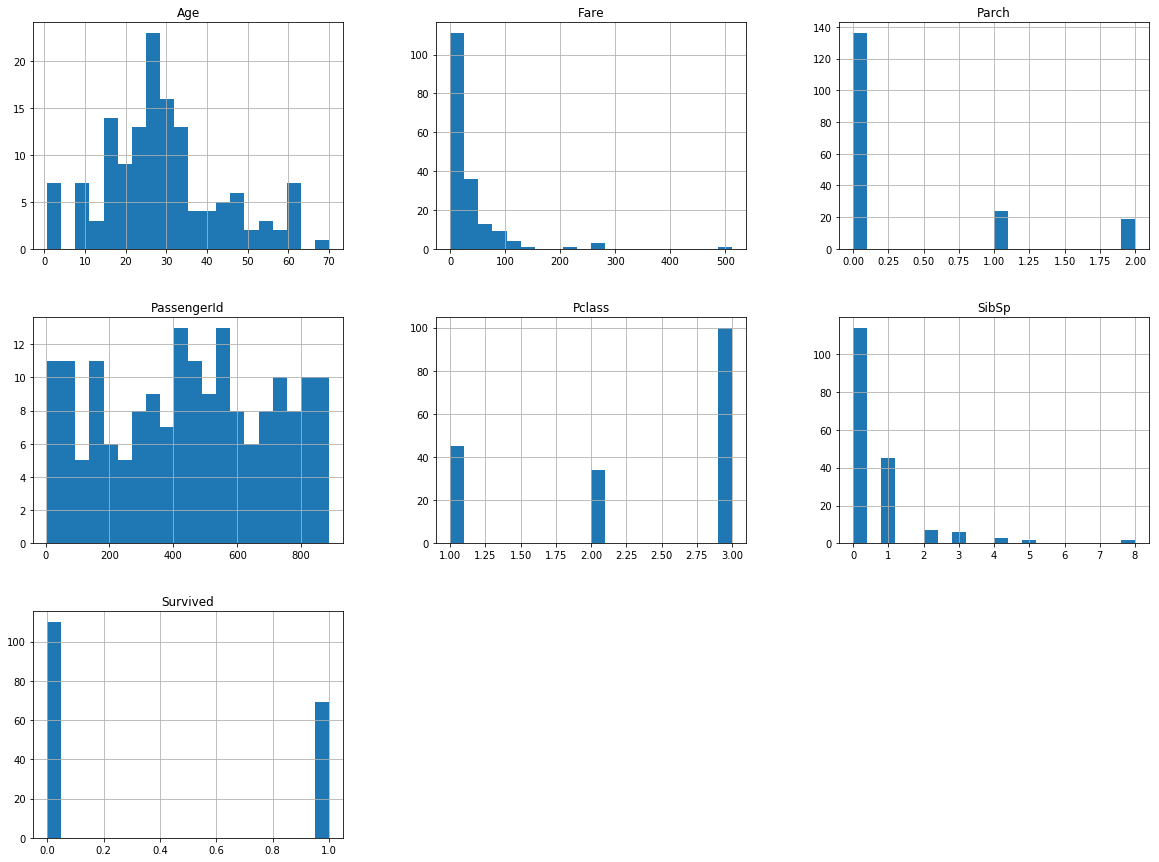

In [37]:
dev_set.hist(bins=20, figsize=(20, 15))
plt.show()

In [42]:
# 制作各种图可视化，看看数据特征的关系等
# 皮尔逊相关系数
# 由相关性矩阵可看出，票的种类和是否活着有比较大的关系，票的种类和票价有很强的正相关性
# 
corr_matrix = train_set.corr()
corr_matrix["Survived"].sort_values(ascending=False)

Survived       1.000000
Fare           0.275499
Parch          0.084178
PassengerId    0.011892
SibSp         -0.026115
Age           -0.084268
Pclass        -0.348007
Name: Survived, dtype: float64

In [44]:
corr_matrix

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,0.011892,-0.031452,0.036080,-0.042990,-0.008022,0.013281
Survived,0.011892,1.000000,-0.348007,-0.084268,-0.026115,0.084178,0.275499
Pclass,-0.031452,-0.348007,1.000000,-0.351089,0.097900,0.040467,-0.556540
Age,0.036080,-0.084268,-0.351089,1.000000,-0.312885,-0.175573,0.106915
SibSp,-0.042990,-0.026115,0.097900,-0.312885,1.000000,0.392269,0.127011
Parch,-0.008022,0.084178,0.040467,-0.175573,0.392269,1.000000,0.177235
Fare,0.013281,0.275499,-0.556540,0.106915,0.127011,0.177235,1.000000


[]

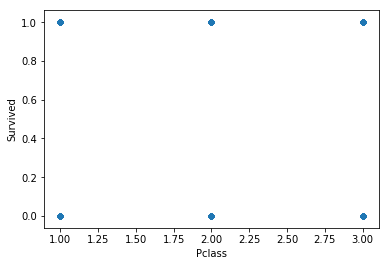

In [45]:
train_set.plot(kind="scatter", x="Pclass", y="Survived")
plt.plot()